In [20]:
import numpy as np, matplotlib.pyplot as plt, random, time, datetime
from functools import lru_cache
from pyquil import Program, get_qc
from pyquil.gates import *
import os
from pyquil.quilatom import quil_sin, quil_cos, Parameter
from pyquil.quilbase import DefGate
from pyquil.latex import display, to_latex
# import Peres_helpers as hf
import pickle
from collections import Counter

Z_SCORE = 3
N_SHOTS = 8192#10_000

# Helpers
def dura(func):
	'''
	A wrapper function to calculate the time of any process we want.
	'''
	def wrapper(*args, **kwargs):
		start = time.time()
		print(f'{func.__name__} has started.')
		val = func(*args, **kwargs)
		ty_res = time.gmtime(time.time() - start)
		res = time.strftime("%H:%M:%S",ty_res)
		print(f'{func.__name__} completed in {res}')
		return val
	return wrapper

def params_real():
	'''
	Generates parameters to prepare random REAL quantum states.
	'''
	theta = np.arccos(np.cos(e) - 2 * np.array([random.uniform(0,1) for _ in range(3)]))
	phi = np.array([(np.pi)*random.randint(0,1) for _ in range(3)])
	params = zip(theta, phi)
	return list(params)
def params_complex():
	'''
	Generates parameters to prepare COMPLEX quantum states.
	'''
	theta = np.arccos(np.cos(e) - 2 * np.array([random.uniform(0,1) for _ in range(3)]))
	phi = np.array([2*np.pi*random.uniform(0,1) for _ in range(3)])
	params = zip(theta, phi)
	return list(params)

e = 0

# Sigma calculation. This function executes the circuit.
def sigma(params, params_ancilla):
	'''
	Compile and run the circuit given the parameters. The list of outputs is returned.
	'''
	params = list(zip(*params)) # Unpack parameters
	theta, phi = params[0], params[1] # Store thetas and phis in seperate tuples.
	
	bitstrings = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'th':[params_ancilla]}) # Stores the output of the circuit run.
	return bitstrings

# Gammas for different pairs of states.
def g(u):
    '''
    Calls the sigma function with different values of parameters correponding to the configurations, |ψ12>, |ψ1> and |ψ2>. Returns a
    dictionary with configurations as keys and output as values (which are lists).
    '''
    params = list(zip(*u)) # Unpack parameters
    theta, phi = params[0], params[1] # Store thetas and phis in seperate tuples.
    s12 = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'theta_m':[np.pi/2]}) # Stores the output of the circuit run.
    s12 = Counter([''.join(list(map(str, elem))) for elem in s12])
    
    #### NEW LINES
    s1 = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'theta_m':[0]}) # Stores the output of the circuit run.
    s1 = Counter([''.join(list(map(str, elem))) for elem in s1])
    
    s2 = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 'theta_m':[np.pi]}) # Stores the output of the circuit run.
    s2 = Counter([''.join(list(map(str, elem))) for elem in s2])
    
    #### NEW LINES END

    return {'s12': s12['01'], 's1': s1['01'], 's2': s2['01']}

# Computing all the three gammas.
# @dura # To calculate the time taken for all the circuits to run.
def f(u):
	'''
	Calls the g function to run the circuit for different configurations and returns a dictionary with 'a', 'b', 'c' as keys and the corresponding 
	outputs of the three configurations. This marks the end of what the Quantum computer must be used for. After this it is all about post-
	processing the data.
	'''
	alpha = g([u[0], u[1]]) # Running for alpha
	beta = g([u[1], u[2]]) # Running for beta
	gamma = g([u[2], u[0]]) # Running for gamma

	res = {'a': alpha, 'b': beta, 'c': gamma}

	return res

def get_gammas(counts):
    res = {}
    for gamma in counts.keys():
        g = (2*counts[gamma]['s12'] - counts[gamma]['s1'] - counts[gamma]['s2']) / (2 * np.sqrt(counts[gamma]['s1']*counts[gamma]['s2']))
        res[gamma] = g

    res['F'] = res['a']**2 + res['b']**2 + res['c']**2 - 2 * res['a'] * res['b'] * res['c']
    return res

def circuit(qubit1, qubit2):
    circ = Program()
    
    c = circ.declare('ro', 'BIT', 2)
    theta = circ.declare('theta', 'REAL', 2)
    phi = circ.declare('phi', 'REAL', 2)
    theta_m = circ.declare('theta_m', 'REAL')
    
    # Preparation of states.
    circ += RY(theta[0], qubit1)
    circ += RZ(phi[0], qubit1)
    
    circ += RY(theta[1], qubit2)
    circ += RZ(phi[1], qubit2)
    
#     circ += X(qubit1)
    
    # Measuring in psi+ basis
    circ += CNOT(qubit1, qubit2)
    circ += RY(-theta_m, qubit1)
#     circ += H(qubit1)
    
    circ += MEASURE(qubit1, c[0])
    circ += MEASURE(qubit2, c[1])
    
    circ.wrap_in_numshots_loop(N_SHOTS)
    
    return circ

def gamma_theory(data):
    u = data['State_params']
    g12 = np.cos(u[1][1] - u[0][1])
    g23 = np.cos(u[2][1] - u[1][1])
    g31 = np.cos(u[0][1] - u[2][1])
    
    data['Gammas_theory'] = {'a': g12, 'b': g23, 'c': g31}
    
    f = g12**2 + g23**2 + g31**2 - 2 * g12 * g23 * g31
    
    data['Gammas_theory']['F'] = f
    
    return data
    

def error_counts_theory(data):
    u = data['State_params']
    s12_a = (1/2) * N_SHOTS * ((np.cos(u[0][0]/2)**2 * np.cos(u[1][0]/2)**2) + (np.sin(u[0][0]/2)**2 * np.sin(u[1][0]/2)**2) + 2 * np.abs(np.cos(u[0][0]/2)* np.cos(u[1][0]/2) * np.sin(u[0][0]/2) * np.sin(u[1][0]/2)) * np.cos((u[1][1] - u[0][1])) )
    s1_a = N_SHOTS * (np.cos(u[0][0]/2)**2 * np.cos(u[1][0]/2)**2)
    s2_a = N_SHOTS * (np.sin(u[0][0]/2)**2 * np.sin(u[1][0]/2)**2)
    
    s12_b = (1/2) * N_SHOTS * ((np.cos(u[1][0]/2)**2 * np.cos(u[2][0]/2)**2) + (np.sin(u[1][0]/2)**2 * np.sin(u[2][0]/2)**2) + 2 * np.abs(np.cos(u[1][0]/2)* np.cos(u[2][0]/2) * np.sin(u[1][0]/2) * np.sin(u[2][0]/2)) * np.cos((u[2][1] - u[1][1])) )
    s1_b = N_SHOTS * (np.cos(u[1][0]/2)**2 * np.cos(u[2][0]/2)**2)
    s2_b = N_SHOTS * (np.sin(u[1][0]/2)**2 * np.sin(u[2][0]/2)**2)
    
    s12_c = (1/2) * N_SHOTS * ((np.cos(u[2][0]/2)**2 * np.cos(u[0][0]/2)**2) + (np.sin(u[2][0]/2)**2 * np.sin(u[0][0]/2)**2) + 2 * np.abs(np.cos(u[2][0]/2)* np.cos(u[0][0]/2) * np.sin(u[2][0]/2) * np.sin(u[0][0]/2)) * np.cos((u[0][1] - u[2][1])) )
    s1_c = N_SHOTS * (np.cos(u[2][0]/2)**2 * np.cos(u[0][0]/2)**2)
    s2_c = N_SHOTS * (np.sin(u[2][0]/2)**2 * np.sin(u[0][0]/2)**2)
    
    data['Counts_theory'] = {'a': {'s12': int(np.round(s12_a)), 's1': int(np.round(s1_a)), 's2': int(np.round(s2_a))}, 'b': {'s12': int(np.round(s12_b)), 's1': int(np.round(s1_b)), 's2': int(np.round(s2_b))}, 'c': {'s12': int(np.round(s12_c)), 's1': int(np.round(s1_c)), 's2': int(np.round(s2_c))}}
#     print(data)
    
    e_s12_a = count_fluctuation(s12_a)
    e_s1_a = count_fluctuation(s1_a)
    e_s2_a = count_fluctuation(s2_a)
    
    e_s12_b = count_fluctuation(s12_b)
    e_s1_b = count_fluctuation(s1_b)
    e_s2_b = count_fluctuation(s2_b)
    
    e_s12_c = count_fluctuation(s12_c)
    e_s1_c = count_fluctuation(s1_c)
    e_s2_c = count_fluctuation(s2_c)
    
    data['Count_fluctuation_theory'] = {'a': {'s12': int(np.round(e_s12_a)), 's1': int(np.round(e_s1_a)), 's2': int(np.round(e_s2_a))}, 'b': {'s12': int(np.round(e_s12_b)), 's1': int(np.round(e_s1_b)), 's2': int(np.round(e_s2_b))}, 'c': {'s12': int(np.round(e_s12_c)), 's1': int(np.round(e_s1_c)), 's2': int(np.round(e_s2_c))}}
#     print(data)
    return data
#     print(s12_c, s1_c, s2_c)

def count_fluctuation(counts):
    return Z_SCORE * np.sqrt((counts/1) * ((N_SHOTS - counts)/1) / N_SHOTS) * 1

# def error_gamma_theory(data):
#     counts = data['Counts_theory']
#     counts_fluc = data['Count_fluctuation_theory']
#     data['Gamma_fluctuation_theory'] = {}
    
#     for g in counts.keys():
#         s12 = counts[g]['s12']
#         s1 = counts[g]['s1']
#         s2 = counts[g]['s2']
        
#         ds12 = counts_fluc[g]['s12']
#         ds1 = counts_fluc[g]['s1']
#         ds2 = counts_fluc[g]['s2']
#         g_vals = np.array([(2*(s12+d12) - (s1+d1) - (s2+d2)) / (2 * np.sqrt((s1+d1)*(s2+d2))) for d12 in range(-ds12, ds12+1) for d1 in range(-ds1, ds1) for d2 in range(-ds2, ds2)]).flatten()
#         g_vals.sort()
#         data['Gamma_fluctuation_theory'][g] = [g_vals[0], g_vals[-1]]
    
#     return data

def error_gamma_theory(data):
    counts = data['Counts_theory']
    counts_fluc = data['Count_fluctuation_theory']
    data['Gamma_fluctuation_theory'] = {}
    
    for g in counts.keys():
        s12 = counts[g]['s12']
        s1 = counts[g]['s1']
        s2 = counts[g]['s2']
        
        ds12 = counts_fluc[g]['s12']
        ds1 = counts_fluc[g]['s1']
        ds2 = counts_fluc[g]['s2']
        g_err_b = (2*ds12 + ds1 + ds2) / (2 * np.sqrt(s1 * s2)) + (2*s12 - s1 - s2) / (s1 * s2)**(3/2) * (s1 * ds2 + s2 * ds1) / 4
        g_err_a = -(2*ds12 + ds1 + ds2) / (2 * np.sqrt(s1 * s2)) - (2*s12 - s1 - s2) / (s1 * s2)**(3/2) * (s1 * ds2 + s2 * ds1) / 4
#         g_vals.sort()
        data['Gamma_fluctuation_theory'][g] = [g_err_a, g_err_b]
    
    g12 = data['Gammas_theory']['a']
    g23 = data['Gammas_theory']['b']
    g31 = data['Gammas_theory']['c']
    
    dg12 = data['Gamma_fluctuation_theory']['a'][1]
    dg23 = data['Gamma_fluctuation_theory']['b'][1]
    dg31 = data['Gamma_fluctuation_theory']['c'][1]
    
    data['Gamma_fluctuation_theory']['F'] = [-(2*dg12*(g12 - g23*g31)*np.sign(g12 - g23*g31) + 2*dg23*(g23 - g12*g31)*np.sign(g23 - g12*g31) + 2*dg31*(g31 - g12*g23)*np.sign(g31 - g12*g23)),2*dg12*(g12 - g23*g31)*np.sign(g12 - g23*g31) + 2*dg23*(g23 - g12*g31)*np.sign(g23 - g12*g31) + 2*dg31*(g31 - g12*g23)*np.sign(g31 - g12*g23)]
    
    return data


In [21]:
result_list = []
q1, q2 = 12, 25
trial=3
# engine = 'Aspen'
# folder = f'product_peres_{engine}_{datetime.date.today()}_{q1}_{q2}_bits_{N_SHOTS}_shots_trial_{trial}'
# # folder = f'product_peres_{engine}_{datetime.date.today()}_{q1}_{q2}_bits_{N_SHOTS}_shots'
# os.system(f'mkdir {folder}')

qc = get_qc('Aspen-9', as_qvm=True) # Initialise QPU.
# qc = get_qc('2q-qvm')

circ = circuit(q1,q2)
exe = qc.compile(circ)

for i in range(2):
    data = {}
    data['State_params'] = params_complex()

    data['Counts'] = f(data['State_params'])
    
#     with open(f'{folder}/run_{i}', 'wb') as file:
#         pickle.dump(data, file)

    all_gammas = get_gammas(data['Counts'])
    data['Gamma'] = all_gammas
    
    result_list.append(data)

    print(f'Done with iteration {i}', end='\r')

# with open(f'{folder}/result_list_trial_{trial}', 'wb') as file:
#     pickle.dump(result_list, file)

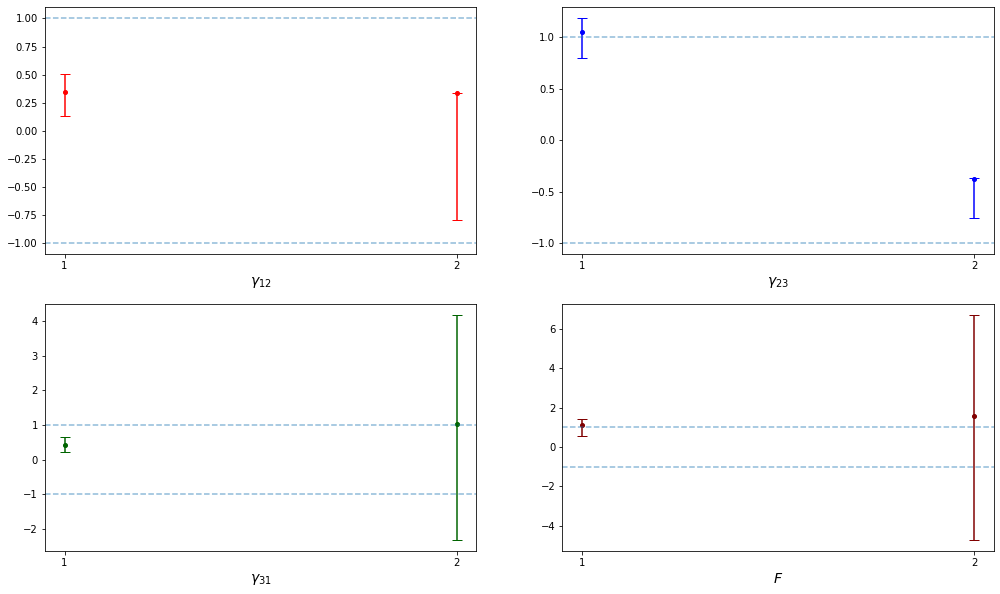

In [22]:
# Import the results from aspen.

# with open('product_peres_Aspen_2021-06-16_12_25_bits_10000_shots_trial_1/result_list_trial_1', 'rb') as file:
#     result_list = pickle.load(file)
# with open('product_peres_Aspen_2021-06-16_12_25_bits_10000_shots_trial_2/result_list_trial_2', 'rb') as file:
#     result_list += pickle.load(file)
# with open('product_peres_Aspen_2021-06-16_12_25_bits_10000_shots_trial_3/result_list_trial_3', 'rb') as file:
#     result_list += pickle.load(file)
for data in result_list:
    data = gamma_theory(data)
    data = error_counts_theory(data)
    data = gamma_theory(data)
    data = error_gamma_theory(data)

all_a = []
all_b = []
all_c = []
all_F = []

all_a_theory = []
all_b_theory = []
all_c_theory = []
all_F_theory = []

all_a_errors = []
all_b_errors = []
all_c_errors = []
all_F_errors = []
for data in result_list:
    all_a.append(data['Gamma']['a'])
    all_b.append(data['Gamma']['b'])
    all_c.append(data['Gamma']['c'])
    all_F.append(data['Gamma']['F'])
    
    all_a_theory.append(data['Gammas_theory']['a'])
    all_b_theory.append(data['Gammas_theory']['b'])
    all_c_theory.append(data['Gammas_theory']['c'])
    all_F_theory.append(data['Gammas_theory']['F'])
    
    
    all_a_errors.append(data['Gamma_fluctuation_theory']['a'][1])
    all_b_errors.append(data['Gamma_fluctuation_theory']['b'][1])
    all_c_errors.append(data['Gamma_fluctuation_theory']['c'][1])
    all_F_errors.append(data['Gamma_fluctuation_theory']['F'][1])
    

x = np.array(list(range(1,len(result_list)+1)))
fig = plt.figure(figsize=(17,10))
plt.subplot(2,2,1)
plt.errorbar(x,all_a_theory, yerr=[all_a_errors, all_a_errors], marker='',fmt='', ls='', capsize=5, color='red', markersize=2)
plt.plot(x, all_a, 'o', color='red', markersize=4)
plt.axhline(y=1, ls='dashed', alpha=0.5)
plt.axhline(y=-1, ls='dashed', alpha=0.5)
plt.xticks(x)
plt.xlabel('$\\gamma_{12}$', size=14)

plt.subplot(2,2,2)
plt.errorbar(x,all_b_theory, yerr=[all_b_errors, all_b_errors], marker='',fmt='', ls='', capsize=5, color='blue', markersize=2)
plt.plot(x, all_b, 'o', color='blue', markersize=4)
plt.axhline(y=1, ls='dashed', alpha=0.5)
plt.axhline(y=-1, ls='dashed', alpha=0.5)
plt.xticks(x)
plt.xlabel('$\\gamma_{23}$', size=14)

plt.subplot(2,2,3)
plt.plot(x, all_c, 'o', color='darkgreen', markersize=4)
plt.errorbar(x,all_c_theory, yerr=[all_c_errors, all_c_errors], marker='',fmt='', ls='', capsize=5, color='darkgreen', markersize=2)
plt.axhline(y=1, ls='dashed', alpha=0.5)
plt.axhline(y=-1, ls='dashed', alpha=0.5)
plt.xticks(x)
plt.xlabel('$\\gamma_{31}$', size=14)

plt.subplot(2,2,4)
plt.errorbar(x,all_F_theory, yerr=[all_F_errors, all_F_errors], marker='',fmt='', ls='', capsize=5, color='maroon', markersize=2)
plt.plot(x, all_F, 'o', color='maroon', markersize=4)
plt.axhline(y=1, ls='dashed', alpha=0.5)
plt.axhline(y=-1, ls='dashed', alpha=0.5)
plt.xticks(x)
plt.xlabel('$F$', size=14)

plt.show()

# Checking optimal qubits

In [23]:
qs = qc.device.get_isa().qubits

In [62]:
for x in qs:
    if x.id in [4,5]:
        print(x, end='\n\n')

Qubit(id=4, type=None, dead=False, gates=[MeasureInfo(operator='MEASURE', qubit=4, target='_', duration=2000, fidelity=0.9620000000000001), MeasureInfo(operator='MEASURE', qubit=4, target=None, duration=2000, fidelity=0.9620000000000001), GateInfo(operator='RZ', parameters=['_'], arguments=[4], duration=0.01, fidelity=1.0), GateInfo(operator='RX', parameters=[0.0], arguments=[4], duration=50, fidelity=1.0), GateInfo(operator='RX', parameters=[3.141592653589793], arguments=[4], duration=50, fidelity=0.9975364503140911), GateInfo(operator='RX', parameters=[-3.141592653589793], arguments=[4], duration=50, fidelity=0.9975364503140911), GateInfo(operator='RX', parameters=[1.5707963267948966], arguments=[4], duration=50, fidelity=0.9975364503140911), GateInfo(operator='RX', parameters=[-1.5707963267948966], arguments=[4], duration=50, fidelity=0.9975364503140911)])

Qubit(id=5, type=None, dead=False, gates=[MeasureInfo(operator='MEASURE', qubit=5, target='_', duration=2000, fidelity=0.945), 

In [50]:
qe = qc.device.get_isa().edges

In [59]:
for x in qe:
    if x.targets in [(4,5)]:
        print(x, end=', ')

Edge(targets=(4, 5), type=None, dead=False, gates=[GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9807270795924907), GateInfo(operator='CPHASE', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.9780874548060001), GateInfo(operator='XY', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.962445115688793)]), 

In [214]:
def check_edges(q1, q2):
    for x in qs:
        if x.id in [q1,q2]:
            print(x.id)
            for i in range(len(x.gates)):
                print(f'{x.gates[i].operator}: {np.round(x.gates[i].fidelity,3)}', end=', ')
            print()
    for x in qe:
        if x.targets == (q1,q2):
            print(x.targets)
            for i in range(len(x.gates)):
                print(f'{x.gates[i].operator}: {np.round(x.gates[i].fidelity)}', end=', ')
            print()

In [215]:
check_edges(12, 25)
check_edges(34, 35)

12
MEASURE: 0.975, MEASURE: 0.975, RZ: 1.0, RX: 1.0, RX: 0.999, RX: 0.999, RX: 0.999, RX: 0.999, 
25
MEASURE: 0.967, MEASURE: 0.967, RZ: 1.0, RX: 1.0, RX: 0.999, RX: 0.999, RX: 0.999, RX: 0.999, 
(12, 25)
CZ: 1.0, XY: 1.0, 
34
MEASURE: 0.963, MEASURE: 0.963, RZ: 1.0, RX: 1.0, RX: 0.996, RX: 0.996, RX: 0.996, RX: 0.996, 
35
MEASURE: 0.961, MEASURE: 0.961, RZ: 1.0, RX: 1.0, RX: 0.998, RX: 0.998, RX: 0.998, RX: 0.998, 
(34, 35)
CZ: 1.0, CPHASE: 1.0, XY: 1.0, 


In [179]:
legit_edges = []

for edge in qe:
    legit=True
    for gate in edge.gates:
        if gate.fidelity == None:
            legit = False
            break
        if gate.fidelity < 0.96:
            legit = False
            break
    if legit == True:
        legit_edges.append(edge)

In [180]:
for x in legit_edges:
    print(x.targets, end=', ')

(4, 5), (10, 11), (10, 17), (12, 25), (21, 22), (21, 36), (22, 35), (23, 24), (33, 34), (34, 35), (35, 36), 

In [181]:
for edge in legit_edges:
    q1, q2 = edge.targets
    legit = True
    for qubit in qs:
        if qubit.id in [q1,q2]:
            for gate in qubit.gates:
                if gate.fidelity < 0.96:
                    legit=False
                    break
    if legit == False:
        if edge in legit_edges:
            legit_edges.remove(edge)
    

In [182]:
legit_edges

[Edge(targets=(10, 11), type=None, dead=False, gates=[GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9807245997727566), GateInfo(operator='CPHASE', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.9769093266331764), GateInfo(operator='XY', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.9789101958332922)]),
 Edge(targets=(12, 25), type=None, dead=False, gates=[GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9731181533088125), GateInfo(operator='XY', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.9665759418496694)]),
 Edge(targets=(21, 36), type=None, dead=False, gates=[GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9630739682808492), GateInfo(operator='CPHASE', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.9808804519492479), GateInfo(operator='XY', parameters=['theta'], arguments=['_', '

In [152]:
qs[0]

Qubit(id=0, type=None, dead=False, gates=[MeasureInfo(operator='MEASURE', qubit=0, target='_', duration=2000, fidelity=0.9670000000000001), MeasureInfo(operator='MEASURE', qubit=0, target=None, duration=2000, fidelity=0.9670000000000001), GateInfo(operator='RZ', parameters=['_'], arguments=[0], duration=0.01, fidelity=1.0), GateInfo(operator='RX', parameters=[0.0], arguments=[0], duration=50, fidelity=1.0), GateInfo(operator='RX', parameters=[3.141592653589793], arguments=[0], duration=50, fidelity=0.9990014768242277), GateInfo(operator='RX', parameters=[-3.141592653589793], arguments=[0], duration=50, fidelity=0.9990014768242277), GateInfo(operator='RX', parameters=[1.5707963267948966], arguments=[0], duration=50, fidelity=0.9990014768242277), GateInfo(operator='RX', parameters=[-1.5707963267948966], arguments=[0], duration=50, fidelity=0.9990014768242277)])

# Statistical fluctuation through repetition

In [23]:
# result_list = []

q1, q2 = 12, 25
trial=2
# engine = 'qvm'
# folder = f'new_peres_{engine}_{datetime.date.today()}_{q1}_{q2}_bits_{N_SHOTS}_shots_trial_{trial}'
# os.system(f'mkdir {folder}')

qc = get_qc('Aspen-9', as_qvm=True) # Initialise QPU.

circ = circuit(q1,q2)
exe = qc.compile(circ)

for result in result_list:
    print(f"States {result['State_params']}", end='\n')
    result['CF99'] = {}
    result['CF100'] = {}
    result['Stats'] = {}
    data = {}
    data['State_params'] = result['State_params']
    data['a'] = []
    data['b'] = []
    data['c'] = []
    data['F'] = []
    for i in range(50):
    #     data = {}
    #     data['State_params'] = params_complex()

        Counts = f(data['State_params'])

    #     with open(f'{folder}/run_{i}', 'wb') as file:
    #         pickle.dump(data, file)

        all_gammas = get_gammas(Counts)
        data['a'].append(all_gammas['a'])
        data['b'].append(all_gammas['b'])
        data['c'].append(all_gammas['c'])
        data['F'].append(all_gammas['F'])
        print(f'Done with iteration {i}', end='\r')

    #     result_list.append(data)

#     print(f'Done with iteration {i}', end='\r')

    samp = data['a']
    samp.sort()
    result['Stats']['a'] = samp
    result['CF99']['a'] = [samp[int(0.005 * len(samp))], samp[int(0.995 * len(samp))]]
    result['CF100']['a'] = [samp[0], samp[-1]]

    samp = data['b']
    samp.sort()
    result['Stats']['b'] = samp
    result['CF99']['b'] = [samp[int(0.005 * len(samp))], samp[int(0.995 * len(samp))]]
    result['CF100']['b'] = [samp[0], samp[-1]]

    samp = data['c']
    samp.sort()
    result['Stats']['c'] = samp
    result['CF99']['c'] = [samp[int(0.005 * len(samp))], samp[int(0.995 * len(samp))]]
    result['CF100']['c'] = [samp[0], samp[-1]]

    samp = data['F']
    samp.sort()
    result['Stats']['F'] = samp
    result['CF99']['F'] = [samp[int(0.005 * len(samp))], samp[int(0.995 * len(samp))]]
    result['CF100']['F'] = [samp[0], samp[-1]]
    
    
# with open(f'{folder}/result_list', 'wb') as file:
#     pickle.dump(result_list, file)

States [(2.3919170086785506, 3.5239088382247026), (1.4131711547811199, 4.767707599806455), (1.9342100002764904, 4.6426613878752)]
States [(3.0041755123395353, 1.971665121259574), (0.5421189005124746, 0.1698746477225219), (2.8095387333445223, 2.335135478049154)]


<ipython-input-20-0e6dd0dec308>:102: RuntimeWarning: divide by zero encountered in double_scalars
  g = (2*counts[gamma]['s12'] - counts[gamma]['s1'] - counts[gamma]['s2']) / (2 * np.sqrt(counts[gamma]['s1']*counts[gamma]['s2']))
<ipython-input-20-0e6dd0dec308>:105: RuntimeWarning: invalid value encountered in double_scalars
  res['F'] = res['a']**2 + res['b']**2 + res['c']**2 - 2 * res['a'] * res['b'] * res['c']


In [24]:
all_a = []
all_b = []
all_c = []
all_F = []

all_cf_a = []
all_cf_b = []
all_cf_c = []
all_cf_F = []

all_mid_a = []
all_mid_b = []
all_mid_c = []
all_mid_F = []


for result in result_list:
    all_a.append(result['Gamma']['a'])
    all_b.append(result['Gamma']['b'])
    all_c.append(result['Gamma']['c'])
    all_F.append(result['Gamma']['F'])
    
    all_mid_a.append((result['CF100']['a'][1] + result['CF100']['a'][0])/2)
    all_mid_b.append((result['CF100']['b'][1] + result['CF100']['b'][0])/2)
    all_mid_c.append((result['CF100']['c'][1] + result['CF100']['c'][0])/2)
    all_mid_F.append((result['CF100']['F'][1] + result['CF100']['F'][0])/2)
    
    all_cf_a.append((result['CF100']['a'][1] - result['CF100']['a'][0])/2)
    all_cf_b.append((result['CF100']['b'][1] - result['CF100']['b'][0])/2)
    all_cf_c.append((result['CF100']['c'][1] - result['CF100']['c'][0])/2)
    all_cf_F.append((result['CF100']['F'][1] - result['CF100']['F'][0])/2)
    
    
    

<ipython-input-24-916b65981da2>:23: RuntimeWarning: invalid value encountered in double_scalars
  all_mid_a.append((result['CF100']['a'][1] + result['CF100']['a'][0])/2)


Text(0, 0.5, '$F$')

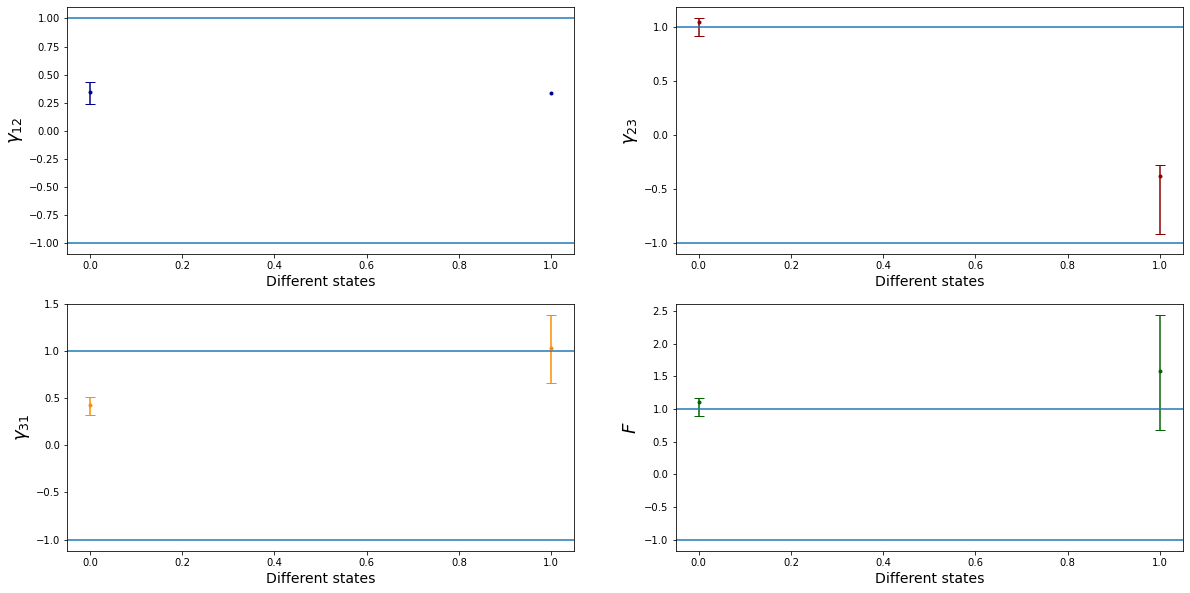

In [25]:
x = np.arange(len(all_a))
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.axhline(y=-1)
plt.axhline(y=1)
plt.plot(x, all_a, '.', color='darkblue')
plt.errorbar(x, all_mid_a, yerr=[all_cf_a, all_cf_a], marker='', fmt='', capsize=5, ls='', color='darkblue')
plt.xlabel('Different states', size=14)
plt.ylabel('$\gamma_{12}$', size=18)

plt.subplot(2,2,2)
plt.axhline(y=-1)
plt.axhline(y=1)
plt.plot(x, all_b, '.', color='darkred')
plt.errorbar(x, all_mid_b, yerr=[all_cf_b, all_cf_b], marker='', fmt='', capsize=5, ls='', color='darkred')
plt.xlabel('Different states', size=14)
plt.ylabel('$\gamma_{23}$', size=18)

plt.subplot(2,2,3)
plt.axhline(y=-1)
plt.axhline(y=1)
plt.plot(x, all_c, '.', color='darkorange')
plt.errorbar(x, all_mid_c, yerr=[all_cf_c, all_cf_c], marker='', fmt='', capsize=5, ls='', color='darkorange')
plt.xlabel('Different states', size=14)
plt.ylabel('$\gamma_{31}$', size=18)

plt.subplot(2,2,4)
plt.axhline(y=-1)
plt.axhline(y=1)
plt.plot(x, all_F, '.', color='darkgreen')
plt.errorbar(x, all_mid_F, yerr=[all_cf_F, all_cf_F], marker='', fmt='', capsize=5, ls='', color='darkgreen')
plt.xlabel('Different states', size=14)
plt.ylabel('$F$', size=18)

# plt.savefig(f'product_peres_on_{datetime.date.today()}.pdf', bbox_inches='tight')

In [384]:
with open(f'product_peres_with_error_from_qvm_{datetime.date.today()}', 'wb') as file:
    pickle.dump(result_list, file)

# Pure statistical error

In [ ]:
data